# Lab | Random Forests

For this lab, you will be using the CSV files provided in the `files_for_lab` folder.

### Instructions

- Apply the Random Forests algorithm but this time only by upscaling the data using `SMOTE`.
- Note that since `SMOTE` works on numerical data only, we will first encode the categorical variables in this case.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
y_path = "/home/sabina/Downloads/Ironhack/Unit 7/lab-random-forests/files_for_lab/target.csv"
y = pd.read_csv(y_path)

cat_path = "/home/sabina/Downloads/Ironhack/Unit 7/lab-random-forests/files_for_lab/categorical.csv"
cat = pd.read_csv(cat_path)

num_path = "/home/sabina/Downloads/Ironhack/Unit 7/lab-random-forests/files_for_lab/numerical.csv"
num = pd.read_csv(num_path)

In [4]:
y.head(10)

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [5]:
cat.head(10)

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,...,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,IL,36,H,F,3,L,E,C,T,2,...,37,12,92,8,94,2,95,12,89,11
1,CA,14,H,M,3,L,G,A,S,1,...,52,2,93,10,95,12,95,12,93,10
2,NC,43,U,M,3,L,E,C,R,2,...,0,2,91,11,92,7,95,12,90,1
3,CA,44,U,F,3,L,E,C,R,2,...,28,1,87,11,94,11,95,12,87,2
4,FL,16,H,F,3,L,F,A,S,2,...,20,1,93,10,96,1,96,1,79,3
5,other,40,H,F,3,L,F,C,T,2,...,0,2,94,7,94,12,95,6,94,1
6,IN,40,H,F,3,L,E,D,T,2,...,60,1,87,5,94,10,95,4,87,1
7,other,39,U,F,1,L,E,C,T,2,...,0,2,95,7,95,8,95,8,94,1
8,other,45,U,M,3,L,F,D,R,2,...,0,2,88,9,93,12,95,7,88,1
9,other,35,H,M,3,L,F,B,T,1,...,32,11,93,9,95,4,95,4,93,9


In [6]:
# Check the categorical columns for any redundant data
cat.columns

Index(['STATE', 'CLUSTER', 'HOMEOWNR', 'GENDER', 'DATASRCE', 'RFA_2R',
       'RFA_2A', 'GEOCODE2', 'DOMAIN_A', 'DOMAIN_B', 'ODATEW_YR', 'ODATEW_MM',
       'DOB_YR', 'DOB_MM', 'MINRDATE_YR', 'MINRDATE_MM', 'MAXRDATE_YR',
       'MAXRDATE_MM', 'LASTDATE_YR', 'LASTDATE_MM', 'FIRSTDATE_YR',
       'FIRSTDATE_MM'],
      dtype='object')

In [7]:
for col in cat.columns:
    print(col, ":", cat[col].unique().shape[0])

STATE : 12
CLUSTER : 53
HOMEOWNR : 2
GENDER : 3
DATASRCE : 3
RFA_2R : 1
RFA_2A : 4
GEOCODE2 : 4
DOMAIN_A : 5
DOMAIN_B : 4
ODATEW_YR : 15
ODATEW_MM : 12
DOB_YR : 96
DOB_MM : 12
MINRDATE_YR : 20
MINRDATE_MM : 12
MAXRDATE_YR : 18
MAXRDATE_MM : 12
LASTDATE_YR : 3
LASTDATE_MM : 12
FIRSTDATE_YR : 26
FIRSTDATE_MM : 12


Feature selection / engineering:
- Remove `RFA_2R`, as it has one unique value only
* Remove `DOB_YR`, as it's already saved as `AGE` in the numerical dataframe
- Remove `GEOCODE` as it's also related to geography and we already have the `STATE` column to represent that data
* Choose either `FIRST_DATE` or `ODATE`, as they represent the same thing (the first time the donor offered a gift)
- Remove `CLUSTER`, as it's a mix of demographic data that can be derived from other features

In [8]:
# Check the maximum difference btwn FIRST_DATE_YR & ODATEW_YR
difference = cat.FIRSTDATE_YR - cat.ODATEW_YR
max_idx = difference.idxmax()
print(cat.FIRSTDATE_YR[max_idx], cat.ODATEW_YR[max_idx])

94 86


In [9]:
# Check the average difference btwn FIRST_DATE_YR & ODATE_YR
np.average(difference)

-0.10794239718274432

In [10]:
to_drop = ["GEOCODE2", "RFA_2R", "FIRSTDATE_YR", "FIRSTDATE_MM", "DOB_YR", "CLUSTER"]
cat.drop(to_drop, axis=1, inplace=True)

In [11]:
num.head(10)

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,0,60.000000,5,9,0,0,39,34,18,10,...,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39
1,1,46.000000,6,9,16,0,15,55,11,6,...,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1
2,1,61.611649,3,1,2,0,20,29,33,6,...,14,2.0,16.0,5.0,12,7.481481,15078,1,4,60
3,0,70.000000,1,4,2,0,23,14,31,3,...,7,2.0,11.0,10.0,9,6.812500,172556,1,4,41
4,0,78.000000,3,2,60,1,28,9,53,26,...,8,3.0,15.0,15.0,14,6.864865,7112,1,2,26
5,0,61.611649,5,9,0,0,26,36,23,7,...,3,10.0,16.0,15.0,6,12.750000,47784,0,1,16
6,0,38.000000,4,6,0,0,33,36,34,7,...,8,3.0,12.0,11.0,4,7.642857,62117,1,1,53
7,0,61.611649,2,9,1,0,34,36,12,3,...,4,5.0,11.0,11.0,6,6.200000,109359,1,3,38
8,1,61.611649,3,2,0,0,33,27,42,5,...,8,10.0,22.0,22.0,8,18.090909,75768,1,1,57
9,1,65.000000,5,9,0,0,28,51,14,5,...,1,3.0,15.0,15.0,7,9.333333,49909,0,1,34


In [ ]:
num.isna().sum()

Index(['TCODE', 'AGE', 'INCOME', 'WEALTH1', 'HIT', 'MALEMILI', 'MALEVET',
       'VIETVETS', 'WWIIVETS', 'LOCALGOV',
       ...
       'CARDGIFT', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'TIMELAG', 'AVGGIFT',
       'CONTROLN', 'HPHONE_D', 'RFA_2F', 'CLUSTER2'],
      dtype='object', length=315)

In [13]:
# Encode categoricals
cat = pd.get_dummies(cat, columns=cat.columns, drop_first=True)

In [22]:
def scale_data(num):
    transformer = MinMaxScaler().fit(num) 
    x_minmax = transformer.transform(num)
    num = pd.DataFrame(x_minmax, columns=num.columns, index=num.index)
    return num

In [23]:
# Scale numerical values
num = scale_data(num)

In [24]:
# Reconnect num & cat columns
X = pd.concat([num, cat], axis=1)

In [25]:
X.shape

(95412, 448)

In [26]:
# Split the targets for the two models
y_regression = y['TARGET_D']
y_classification = y['TARGET_B']

In [27]:
# Function to plot confusion matrices & calculate prediction scores
def validate_model(y_pred, y_test):
    cm = confusion_matrix(y_pred, y_test)
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=["No", "Yes"], \
        yticklabels=["No", "Yes"])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
    print("Accuracy:", 100 * round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", 100 * round(precision_score(y_test, y_pred), 4))
    print("Recall:", 100 * round(recall_score(y_test, y_pred), 4))

In [18]:
# Plot the true positive against the false negative rate
def roc_auc_validation(y_pred_proba, y_test):
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label="data 1, auc=" + str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

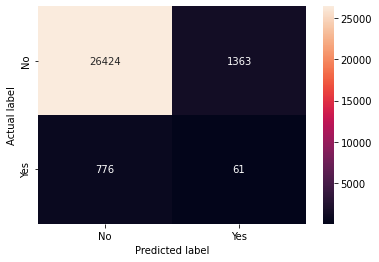

Accuracy: 92.53
Precision: 7.290000000000001
Recall: 4.279999999999999


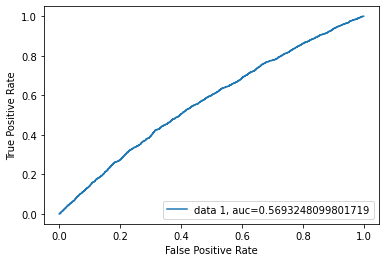

In [28]:
# Train-test split for the classification model
X_train, X_test, y_ctrain, y_ctest = train_test_split(X, y_classification, \
    test_size=0.3, random_state=42)

# Apply oversampling technique to training set
X_sm, y_csm = SMOTE().fit_resample(X_train, y_ctrain)

# Fit Random Forest Classifier to data & predict
model = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42)
model.fit(X_sm, y_csm)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Check the accuracy of the model
validate_model(y_pred, y_ctest)
roc_auc_validation(y_pred_proba, y_ctest)

In [20]:
# Train-test split for the regression model
X_train, X_test, y_rtrain, y_rtest = train_test_split(X, y_regression, \
    test_size=0.3, random_state=42)

# Apply oversampling technique to training set
X_sm, y_rsm = SMOTE().fit_resample(X_train, y_rtrain)

# Fit Random Forest Regressor to data & predict
model = RandomForestRegressor()
model.fit(X_sm, y_rsm)
y_pred = model.predict(X_test)

# Check the accuracy of the model


ValueError: Unknown label type: 'continuous'